CONFIG
---------------------------------------------------------
config                         noise.yaml
if_add_reverb                  True
if_add_noise                   True
RoomInfo                       ./room-info-real-small
RirInfo                        ./rir-info-real-small
NoiseInfo                      ./noise-info
SnrInfo                        [-7.0, 6.0]
RirRatio                       1
NoiseRatio                     1
---------------------------------------------------------
----------
Source: ./input_speech.wav
----------
 - File size: 173132 bytes
 - AudioMetaData(sample_rate=16000, num_frames=86544, num_channels=1, bits_per_sample=16, encoding=PCM_S)


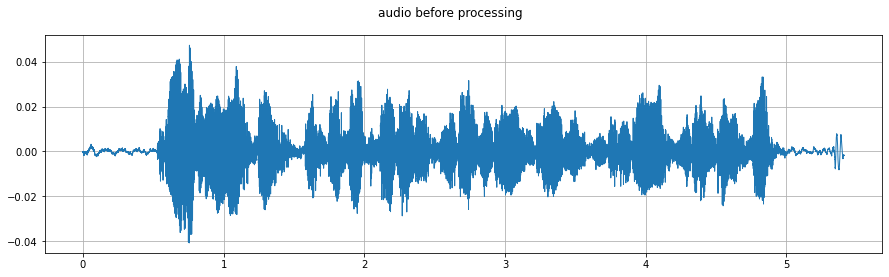

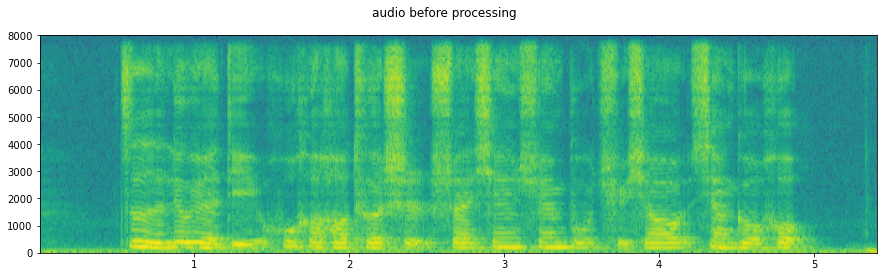

Info: room info loaded
Info: rir info loaded
Info: noise info loaded
Info: snr info loaded
Info: rir ratio loaded
Info: noise ratio loaded
----------
Source: ./kaldi-noise-cfg-filtered/noise-rir/rir-reall-small/Room142-00074.wav
----------
 - File size: 16044 bytes
 - AudioMetaData(sample_rate=16000, num_frames=8000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


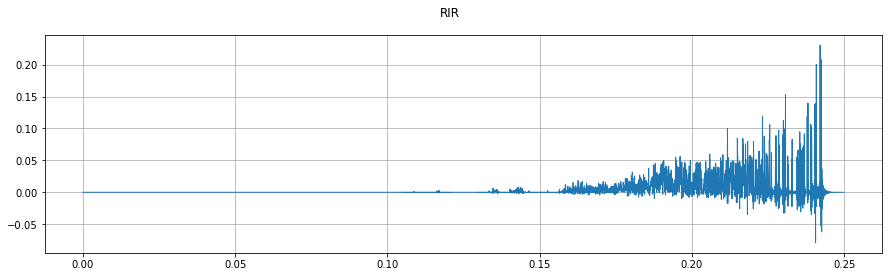

/home/dingchaoyue/anaconda3/envs/draw/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


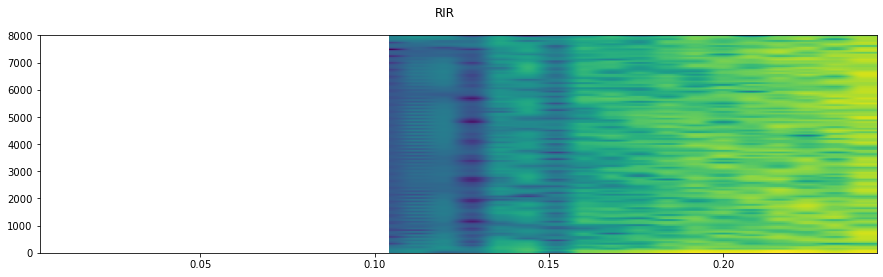

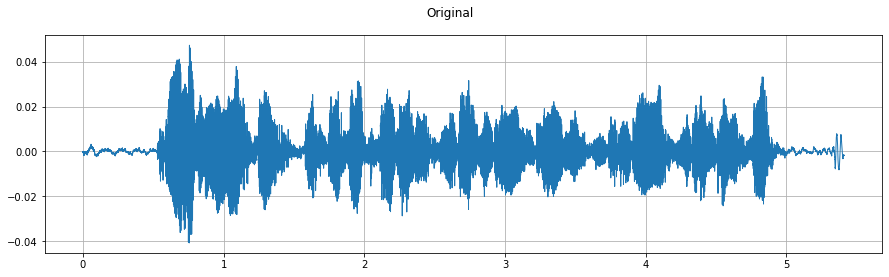

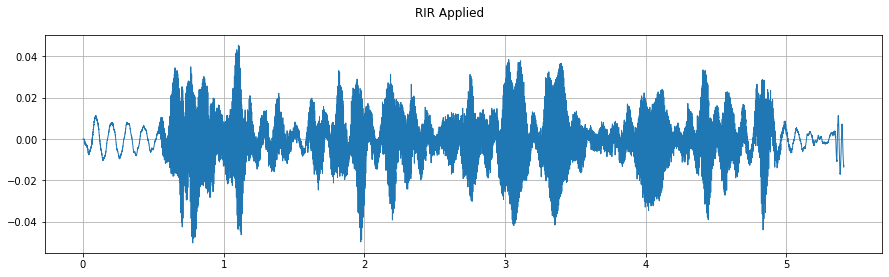

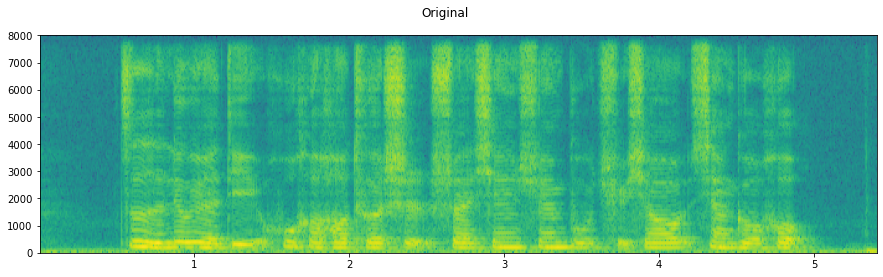

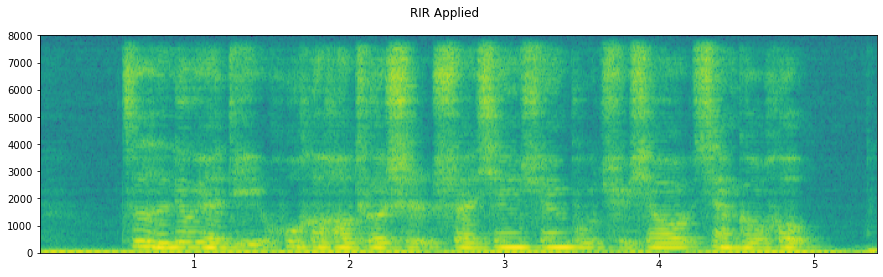

----------
Source: ./kaldi-noise-cfg-filtered/noise-rir/babble.wav
----------
 - File size: 7527418 bytes
 - AudioMetaData(sample_rate=16000, num_frames=3763687, num_channels=1, bits_per_sample=16, encoding=PCM_S)
noiseShape torch.Size([1, 3763687])
speechShape torch.Size([1, 86544])
noiseStart: 801984


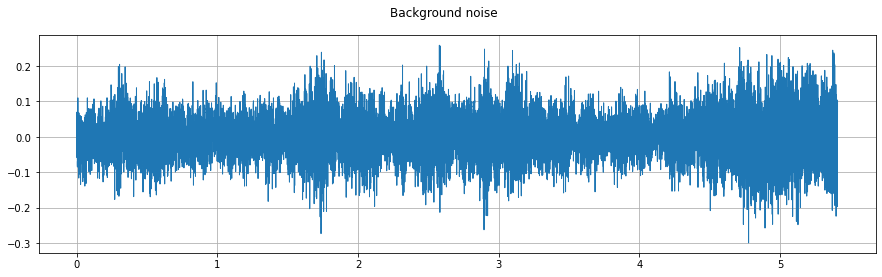

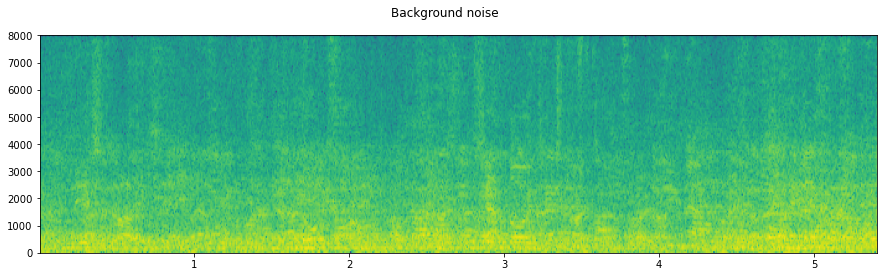

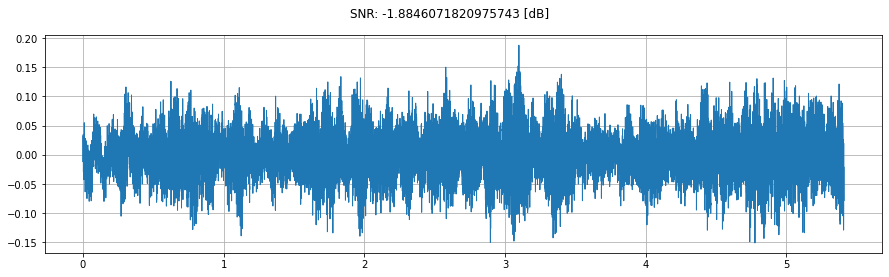

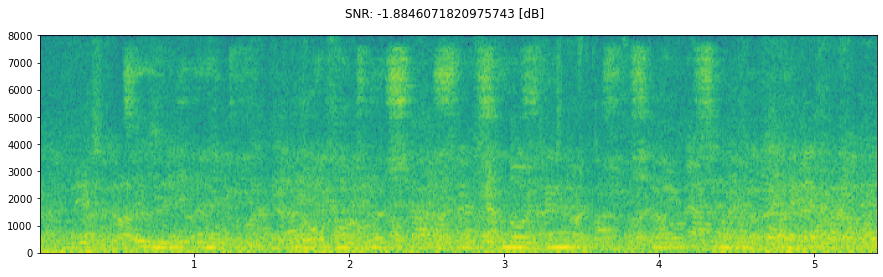

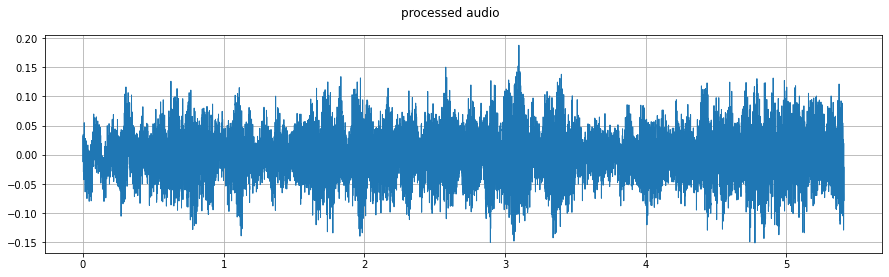

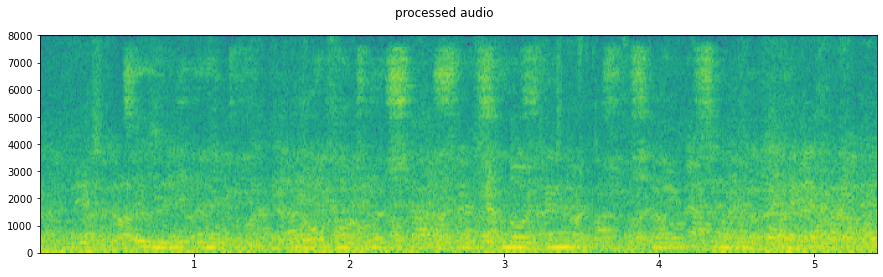

----------
Source: ./output.wav
----------
 - File size: 346234 bytes
 - AudioMetaData(sample_rate=16000, num_frames=86544, num_channels=1, bits_per_sample=32, encoding=PCM_F)


In [17]:
import yaml
import math
import os
import logging
import torch
import argparse
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from tools import plot_waveform, plot_specgram, play_audio, inspect_file
import random

class Room:
    def __init__(self, _id, _roomName):
        self._id = _id
        self._roomName = _roomName

class Rir:
    def __init__(self, _id, _rirName, _roomName, _rirPath):
        self._id = _id
        self._rirName = _rirName
        self._roomName = _roomName
        self._rirPath = _rirPath

class Noise:
    def __init__(self, _id, _noiseName, _bgorfg, _noiseType, _noisePath):
        self._id = _id
        self._noiseName = _noiseName
        self._bgorfg = _bgorfg  # 背景噪音还是前景噪音
        self._noiseType = _noiseType
        self._noisePath = _noisePath

def conduct_reverb(speech, rir, sample_rate):
    # rir, _ = torchaudio.load("./_sample_data/rir.wav")  # test rir
    # we convolve the speech signal with the RIR filter.
    # rir = rir_raw[:, int(sample_rate*0.2):int(sample_rate*1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    rir = rir[:, int(0.5*rir.size(1)):]

    speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
    augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

    plot_waveform(rir, sample_rate, title="RIR", ylim=None)
    plot_specgram(rir, sample_rate, title="RIR")
    play_audio(rir, sample_rate)
    
    plot_waveform(speech, sample_rate, title="Original", ylim=None)
    plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)

    plot_specgram(speech, sample_rate, title="Original")
    play_audio(speech, sample_rate)

    plot_specgram(augmented, sample_rate, title="RIR Applied")
    play_audio(augmented, sample_rate)
    return augmented

def conduct_noise(speech, noise, snr_db, sample_rate):
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> background noise >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    len_noise = noise.size(1)
    len_speech = speech.size(1)
    print("noiseShape", noise.shape)
    print("speechShape", speech.shape)
    if(len_noise<len_speech):
        print("noise length error")
        return
    start = random.randint(0, len_noise-len_speech)
    noise = noise[:, start:start+speech.shape[1]]  # Randomly pick a starting position
    
    print(f"noiseStart: {start}")

    plot_waveform(noise, sample_rate, title="Background noise")
    plot_specgram(noise, sample_rate, title="Background noise")
    play_audio(noise, sample_rate)

    speech_power = speech.norm(p=2)
    noise_power = noise.norm(p=2)

    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    noisy_speech = (scale * speech + noise) / 2

    plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
    plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
    play_audio(noisy_speech, sample_rate)
    
    return noisy_speech

# from typing import Tensor
class NoiseAdder():
    def __init__(self, args):
        self.roomList = []
        self.noiseList = []
        self.rirList = []
        self.args = args

    def load_room(self):
        if self.args.RoomInfo == "":
            print("Error: error room info config")
            return -1
        with open(self.args.RoomInfo, "r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                data = line.strip().split()
                self.roomList.append(Room(len(self.roomList), data[1]))
        print("Info: room info loaded")
        return 0

    def load_rir(self):
        if self.args.RirInfo == "":
            print("Error: error rir info config")
            return -2
        with open(self.args.RirInfo, "r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                data = line.strip().split()
                if os.access(data[2], os.R_OK) == False:
                    logging.warning(f"Warning: rir file {data[2]} can not be access, skip it")
                self.rirList.append(Rir(len(self.rirList), data[0], data[1], data[2]))
        print("Info: rir info loaded")
        return 0

    def load_noise(self):
        if self.args.NoiseInfo == "":
            print("Error: error noise info config")
            return -3
        with open(self.args.NoiseInfo, "r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                data = line.strip().split()
                if (data[0][0] == '#'):
                    continue;
                if data[1]!="isotropic" and data[1]!="point-source":
                    logging.warning("Warning: error noise-type(isotropic|point-source) ", data[1])
                    continue;
                if data[2]!="background" and data[2]!="foreground":
                    logging.warning("Warning: error fg-bg-type(background|foreground) ",data[2])
                    continue
                if data[3] != "free":
                    logging.warning("Warning: error noise type) ",data[3])
                    continue
                if os.access(data[4], os.R_OK) == False:
                    logging.warning(f"Warning: noise file {data[4]} can not be access, skip it")
                    continue
                lens = len(data[4])
                if lens <= 0:
                    logging.warning(f"Warning: noise file {data[4]} can not be access, skip it")
                    continue;
                self.noiseList.append(Noise(data[0], data[1], data[2], data[3], data[4]))
        print("Info: noise info loaded")
        return 0
            
                
    # def chooseRoomNum(self):  // pending
    #     return random.randchoice(self.roomList)

    def chooseRir(self):
        return self.rirList[random.randint(0, len(self.rirList)-1)]

    def chooseNoise(self):
        return self.noiseList[random.randint(0, len(self.noiseList)-1)]

    def doNoise(self):
        if(random.random() <= args.NoiseRatio):
            return True
        else:
            return False

    def doReverberation(self):
        if(random.random() <= args.RirRatio):
            return True
        else:
            return False   

    def add_noise(self, ori_wav):
        # ori_wav -> noise_wav
        
        # obj_room = self.chooseRoomNum()  # pending
   
        # add_reverb
        if args.if_add_reverb==True and self.doReverberation()==True:
            rir_obj = self.chooseRir()
            rir_wav, rir_sample_rate = torchaudio.load(rir_obj._rirPath)
            inspect_file(rir_obj._rirPath)
            ori_wav = conduct_reverb(ori_wav, rir_wav, rir_sample_rate)

        # add_noise
        if args.if_add_noise==True and self.doNoise()==True:
            noise_obj = self.chooseNoise()
            noise_wav, noise_sample_rate = torchaudio.load(noise_obj._noisePath)
            inspect_file(noise_obj._noisePath)
            snr_db = random.uniform(args.SnrInfo[0], args.SnrInfo[1])
            ori_wav = conduct_noise(ori_wav, noise_wav, snr_db, noise_sample_rate)
        return ori_wav

def print_args(args):
    print('CONFIG', flush=True)
    print('---------------------------------------------------------', flush=True)
    max_tab = 30
    for k, v in vars(args).items():
        cur_tab = len(k)
        print(k + ' '*(max_tab - cur_tab + 1) + str(v))
    print('---------------------------------------------------------', flush=True)

def main(args):
    if "RoomInfo" not in args:
        logging.error("Error: error room info config")
    if "RirInfo" not in args:
        logging.error("Error: error rir info config")
    if "NoiseInfo" not in args:
        logging.error("Error: error noise info config")
    if "SnrInfo" not in args:
        logging.error("Error: error snr info config")
    if "RirRatio" not in args:
        logging.error("Error: error rir ratio config")
    if "NoiseRatio" not in args:
        logging.error("Error: error Noise Ratio config")
    input_speech_path = "./input_speech.wav"
    input_speech, sample_rate = torchaudio.load(input_speech_path)
    inspect_file(input_speech_path)
    plot_waveform(input_speech, sample_rate, title="audio before processing")
    plot_specgram(input_speech, sample_rate, title="audio before processing")
    play_audio(input_speech, sample_rate)
    n = NoiseAdder(args)
    if(n.load_room()):
        print("Error: load room info failed")
    if(n.load_rir()):
        print("Error: load rir info failed")
    if(n.load_noise()):
        print("Error: load noise info failed")
    if("SnrInfo" in args):
        print("Info: snr info loaded")
    else:
        print("Error: load snr info failed")
    if("RirRatio" in args):
        print("Info: rir ratio loaded")
    else:
        print("Error: load rir ratio failed")
    if("NoiseRatio" in args):
        print("Info: noise ratio loaded")
    else:
        print("Error: load noise ratio failed")
        
    output_speech = n.add_noise(input_speech)
    plot_waveform(output_speech, sample_rate, title="processed audio")
    plot_specgram(output_speech, sample_rate, title="processed audio")
    play_audio(output_speech, sample_rate)
    path = "./output_speech.wav"
    torchaudio.save(path, output_speech, sample_rate)
    inspect_file(path)

# python NoiseAdder.py --config ./nosie.yaml
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='test asr')
    parser.add_argument('--config', default='noise.yaml', type=str, help='path to config file')
    parser.add_argument('--if-add-reverb', default='True', type=bool, help='whether to add reverberation')
    parser.add_argument('--if-add-noise', default='True', type=bool, help='whether to add noise')
    # args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    with open(args.config) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        for key, value in config.items():
            setattr(args, key, value)
    args.SnrInfo = [item for item in map(float, args.SnrInfo.strip().split())]
    print_args(args)
    main(args)